# 1. Setup

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
language = 'Tamil'
data_dir = f'Data/{language}'
train_dir = f'{data_dir}/Train'
val_dir = f'{data_dir}/Val'
test_dir = f'{data_dir}/Test'

In [3]:
character_df_fp = f'Data/Characters/Characters-{language}.csv'

In [4]:
cpu_count = 16
print(cpu_count)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

16
cuda


# 2. Define character class

In [5]:
character_df = pd.read_csv(character_df_fp)
print(character_df.shape)
character_df.head()

(247, 3)


,Character,Consonant,Glyph
0,அ,-,-
1,ஆ,-,ா
2,இ,-,ி
3,ஈ,-,ீ
4,உ,-,ு


In [6]:
#character_df[character_df['Consonant']=="-"]

In [7]:
characters = set()
for character in character_df['Character'].values:
    characters.update(list(character))
characters = ["-"] + sorted(list(characters))
print(len(characters))
print(characters)

44
['-', 'ஃ', 'அ', 'ஆ', 'இ', 'ஈ', 'உ', 'ஊ', 'எ', 'ஏ', 'ஐ', 'ஒ', 'ஓ', 'ஔ', 'க', 'ங', 'ச', 'ஞ', 'ட', 'ண', 'த', 'ந', 'ன', 'ப', 'ம', 'ய', 'ர', 'ற', 'ல', 'ள', 'ழ', 'வ', 'ா', 'ி', 'ீ', 'ு', 'ூ', 'ெ', 'ே', 'ை', 'ொ', 'ோ', 'ௌ', '்']


In [8]:
idx2char = {k:v for k,v in enumerate(characters)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

{0: '-', 1: 'ஃ', 2: 'அ', 3: 'ஆ', 4: 'இ', 5: 'ஈ', 6: 'உ', 7: 'ஊ', 8: 'எ', 9: 'ஏ', 10: 'ஐ', 11: 'ஒ', 12: 'ஓ', 13: 'ஔ', 14: 'க', 15: 'ங', 16: 'ச', 17: 'ஞ', 18: 'ட', 19: 'ண', 20: 'த', 21: 'ந', 22: 'ன', 23: 'ப', 24: 'ம', 25: 'ய', 26: 'ர', 27: 'ற', 28: 'ல', 29: 'ள', 30: 'ழ', 31: 'வ', 32: 'ா', 33: 'ி', 34: 'ீ', 35: 'ு', 36: 'ூ', 37: 'ெ', 38: 'ே', 39: 'ை', 40: 'ொ', 41: 'ோ', 42: 'ௌ', 43: '்'}
{'-': 0, 'ஃ': 1, 'அ': 2, 'ஆ': 3, 'இ': 4, 'ஈ': 5, 'உ': 6, 'ஊ': 7, 'எ': 8, 'ஏ': 9, 'ஐ': 10, 'ஒ': 11, 'ஓ': 12, 'ஔ': 13, 'க': 14, 'ங': 15, 'ச': 16, 'ஞ': 17, 'ட': 18, 'ண': 19, 'த': 20, 'ந': 21, 'ன': 22, 'ப': 23, 'ம': 24, 'ய': 25, 'ர': 26, 'ற': 27, 'ல': 28, 'ள': 29, 'ழ': 30, 'வ': 31, 'ா': 32, 'ி': 33, 'ீ': 34, 'ு': 35, 'ூ': 36, 'ெ': 37, 'ே': 38, 'ை': 39, 'ொ': 40, 'ோ': 41, 'ௌ': 42, '்': 43}


# 3. Define data loader

In [9]:
class IndianSceneTextDataset(Dataset):
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_fns = os.listdir(data_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split("_")[0][:13]
        return image, text, image_fn
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [10]:
trainset = IndianSceneTextDataset(train_dir) 
valset = IndianSceneTextDataset(val_dir) 
testset = IndianSceneTextDataset(test_dir) 
print(len(trainset), len(valset), len(testset))

train_loader = DataLoader(trainset, batch_size=16, num_workers=8, shuffle=True)
val_loader = DataLoader(valset, batch_size=16, num_workers=8, shuffle=False)
test_loader = DataLoader(testset, batch_size=16, num_workers=8, shuffle=False)
print(len(train_loader), len(val_loader), len(test_loader))

500000 5000 5000
31250 313 313


In [11]:
image_batch, text_batch, image_fn_batch = iter(train_loader).next()
print(image_batch.size())
print(text_batch)

torch.Size([16, 3, 50, 200])
('பல', 'பராசர', 'சமன்', 'இடம்', 'வளரத்', 'ஆலய', 'வயல்', 'பரணி', 'ஐயை', 'தல', 'எம்', 'பல', 'தளிதனி', 'வன', 'மடை', 'ஊக்கம்')


In [12]:
def tokenize(text):

    text_tokens = list(text)
    
    return text_tokens

In [13]:
for text in text_batch:
    print(text, tokenize(text))

பல ['ப', 'ல']
பராசர ['ப', 'ர', 'ா', 'ச', 'ர']
சமன் ['ச', 'ம', 'ன', '்']
இடம் ['இ', 'ட', 'ம', '்']
வளரத் ['வ', 'ள', 'ர', 'த', '்']
ஆலய ['ஆ', 'ல', 'ய']
வயல் ['வ', 'ய', 'ல', '்']
பரணி ['ப', 'ர', 'ண', 'ி']
ஐயை ['ஐ', 'ய', 'ை']
தல ['த', 'ல']
எம் ['எ', 'ம', '்']
பல ['ப', 'ல']
தளிதனி ['த', 'ள', 'ி', 'த', 'ன', 'ி']
வன ['வ', 'ன']
மடை ['ம', 'ட', 'ை']
ஊக்கம் ['ஊ', 'க', '்', 'க', 'ம', '்']


# 4. Define model

In [14]:
resnet = resnet18(pretrained=True)
#print(resnet)

In [15]:
for p in resnet.parameters():
    pass#p.requires_grad = False

In [16]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.5)
        self.dp3 = nn.Dropout(p=0.5)
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            num_layers=2,
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True,
                            num_layers=1, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        batch = self.dp1(batch)
        # print(batch.size())# torch.Size([-1, 256, 4, 13])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 13, 256, 4])
        
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 13, 1024])
        
        batch = self.linear1(batch)
        batch = self.dp2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn2(batch)
        batch = self.dp3(batch)
        # print(batch.size()) # torch.Size([-1, 13, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 375])
        
        batch = batch.permute(1, 0, 2) # [T, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([13, -1, 375])
        
        return batch

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [18]:
crnn = CRNN(num_chars=len(char2idx), rnn_hidden_size=256)
#crnn.apply(weights_init)
crnn = crnn.to(device)

In [19]:
#crnn

In [20]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('பல', 'பராசர', 'சமன்', 'இடம்', 'வளரத்', 'ஆலய', 'வயல்', 'பரணி', 'ஐயை', 'தல', 'எம்', 'பல', 'தளிதனி', 'வன', 'மடை', 'ஊக்கம்')
torch.Size([13, 16, 44])


In [21]:
#text_batch_logits.log_softmax(2)

# 5. Define loss

In [22]:
criterion = nn.CTCLoss(blank=0)

In [23]:
def encode_text_batch(text_batch):
    
    text_batch = [tokenize(text) for text in text_batch]
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = []
    for text in text_batch:
        for token in text:
            text_batch_concat.append(token)
 
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [24]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [25]:
compute_loss(text_batch, text_batch_logits)

tensor(12.9753, device='cuda:0', grad_fn=<MeanBackward0>)

# 6. Train model

In [26]:
# Hyperparameters: Data Loading
batch_size = 64

# Hyperparameters: Model Architecture
rnn_hidden_size = 256

# Hyperparameters: Training
num_epochs = 30
lr = 0.00081
weight_decay = 1e-5
clip_norm = 5
step_size = 5
gamma = 0.90

In [27]:
trainset = IndianSceneTextDataset(train_dir) 
valset = IndianSceneTextDataset(val_dir) 

train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=8, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, num_workers=8, shuffle=False)

crnn = CRNN(num_chars=len(char2idx), rnn_hidden_size=rnn_hidden_size)
#crnn.apply(weights_init)
model_path = f'Models/{language}-Unicode-e10.pth'
crnn.load_state_dict(torch.load(model_path))
crnn = crnn.to(device)

optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [28]:
epoch_losses = []
epoch_losses_val = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(11, num_epochs+1)):
    epoch_loss_list = [] 
    epoch_loss_list_val = []
    num_updates_epoch = 0

    crnn.train()
    for image_batch, text_batch, image_fn_batch in tqdm(train_loader, leave=False, desc="Train"):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()
        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    crnn.eval()
    for image_batch, text_batch, image_fn_batch in tqdm(val_loader, leave=False, desc="Val"):
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()
        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
        epoch_loss_list_val.append(iteration_loss)


    epoch_loss = np.mean(epoch_loss_list)
    epoch_loss_val = np.mean(epoch_loss_list_val)
    print("Epoch:{}    TrainLoss:{}    ValLoss:{}    NumUpdates:{}    LR:{}".\
          format(epoch, epoch_loss, epoch_loss_val, num_updates_epoch, optimizer.param_groups[0]['lr']))
    epoch_losses.append(epoch_loss)
    epoch_losses_val.append(epoch_loss_val)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step()
    
    if epoch % 10 == 0:
        model_path = f'Models/{language}-Unicode-e{epoch}.pth'
        torch.save(crnn.state_dict(), model_path)

Epoch:11    TrainLoss:0.5482868853664179    ValLoss:0.5920148993594737    NumUpdates:7813    LR:0.00081


Epoch:12    TrainLoss:0.5330959683896621    ValLoss:0.5883205380243591    NumUpdates:7813    LR:0.00081


Epoch:13    TrainLoss:0.5229097954231784    ValLoss:0.5931748396988157    NumUpdates:7813    LR:0.00081


Epoch:14    TrainLoss:0.5151444806662623    ValLoss:0.5735027714620663    NumUpdates:7813    LR:0.00081


Epoch:15    TrainLoss:0.5072092362893508    ValLoss:0.57543578857108    NumUpdates:7813    LR:0.00081


Epoch:16    TrainLoss:0.4827997675076133    ValLoss:0.5665360304373729    NumUpdates:7813    LR:0.0007289999999999999


Epoch:17    TrainLoss:0.47494754744113127    ValLoss:0.5542759059727946    NumUpdates:7813    LR:0.0007289999999999999


Epoch:18    TrainLoss:0.46803455744794553    ValLoss:0.5642561582447607    NumUpdates:7813    LR:0.0007289999999999999


Epoch:19    TrainLoss:0.4626887514987005    ValLoss:0.5569534699750852    NumUpdates:7813    LR:0.0007289999999999999


Epoch:20    TrainLoss:0.457410243126108    ValLoss:0.5443127977697155    NumUpdates:7813    LR:0.0007289999999999999


Epoch:21    TrainLoss:0.437247159308292    ValLoss:0.5491338868307162    NumUpdates:7813    LR:0.0006561


Epoch:22    TrainLoss:0.42905517275882993    ValLoss:0.5328203724532188    NumUpdates:7813    LR:0.0006561


Epoch:23    TrainLoss:0.4238437946304597    ValLoss:0.5480462369285052    NumUpdates:7813    LR:0.0006561


Epoch:24    TrainLoss:0.4192653995631416    ValLoss:0.5277954170221015    NumUpdates:7813    LR:0.0006561


Epoch:25    TrainLoss:0.4173555719363053    ValLoss:0.535737278340738    NumUpdates:7813    LR:0.0006561


Epoch:26    TrainLoss:0.39789249550021444    ValLoss:0.5384631966111026    NumUpdates:7813    LR:0.0005904899999999999


Epoch:27    TrainLoss:0.39136395159702086    ValLoss:0.547014100642144    NumUpdates:7813    LR:0.0005904899999999999


Epoch:28    TrainLoss:0.38710592861688886    ValLoss:0.5380816538877125    NumUpdates:7813    LR:0.0005904899999999999


Epoch:29    TrainLoss:0.38313489292819675    ValLoss:0.527948263513891    NumUpdates:7813    LR:0.0005904899999999999


Epoch:30    TrainLoss:0.38079490206070493    ValLoss:0.5364158196917063    NumUpdates:7813    LR:0.0005904899999999999



In [29]:
model_path = f'Models/{language}-Unicode.pth'
torch.save(crnn.state_dict(), model_path)

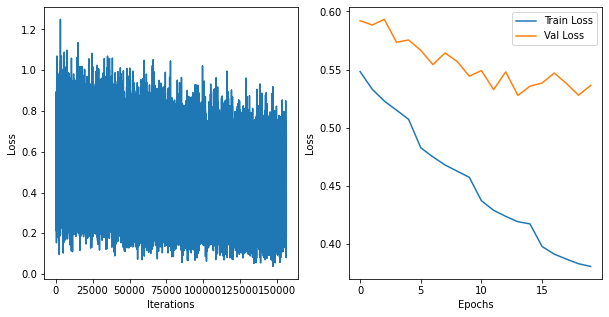

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(iteration_losses)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")

ax2.plot(epoch_losses, label="Train Loss")
ax2.plot(epoch_losses_val, label="Val Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")

plt.legend()
plt.show()

# 7. Make predictions

In [31]:
#trainset = IndianSceneTextDataset(train_dir) 
#valset = IndianSceneTextDataset(val_dir)
testset = IndianSceneTextDataset(test_dir) 

#train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=8, shuffle=False)
#val_loader = DataLoader(valset, batch_size=batch_size, num_workers=8, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=8, shuffle=False)

In [32]:
model_path = f'Models/{language}-Unicode.pth'

crnn = CRNN(len(char2idx), rnn_hidden_size=rnn_hidden_size)
crnn.load_state_dict(torch.load(model_path))
crnn = crnn.to(device)

In [33]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [34]:
def make_predictions(data_loader):
    result = pd.DataFrame(columns=['image_fn', 'actual', 'prediction'])
    with torch.no_grad():
        for image_batch, text_batch, image_fn_batch in tqdm(data_loader, leave=False):
            text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            #print(text_batch, text_batch_pred)
            df = pd.DataFrame(columns=['actual', 'prediction'])
            df['image_fn'] = image_fn_batch
            df['actual'] = text_batch
            df['prediction'] = text_batch_pred
            result = pd.concat([result, df])
    result = result.reset_index(drop=True)
    return result

In [35]:
train_result = make_predictions(train_loader)
val_result = make_predictions(val_loader)
test_result = make_predictions(test_loader)

In [36]:
print(train_result.shape)
print(val_result.shape)
print(test_result.shape)
train_result.head()

(500000, 3)
(5000, 3)
(5000, 3)


,image_fn,actual,prediction
0,தள_7_251_6.jpg,தள,தல-----------
1,சஅ_4_3247_1.jpg,சஅ,சஅ-----------
2,கன_5_4131_3.jpg,கன,கன-----------
3,ஓலை_10_2664_4.jpg,ஓலை,ஓல----------ை
4,ஏப்ரல்_4_1192_5.jpg,ஏப்ரல்,ஏப---்்ர---ல்


In [37]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [38]:
train_result['prediction_corrected'] = train_result['prediction'].apply(correct_prediction)
val_result['prediction_corrected'] = val_result['prediction'].apply(correct_prediction)
test_result['prediction_corrected'] = test_result['prediction'].apply(correct_prediction)

In [39]:
train_result['actual_length'] = train_result['actual'].apply(len)
val_result['actual_length'] = val_result['actual'].apply(len)
test_result['actual_length'] = test_result['actual'].apply(len)

train_result['prediction_length'] = train_result['prediction_corrected'].apply(len)
val_result['prediction_length'] = val_result['prediction_corrected'].apply(len)
test_result['prediction_length'] = test_result['prediction_corrected'].apply(len)

In [40]:
def levenshteinDistance(row):
    
    s1 = row['actual']
    s2 = row['prediction_corrected']
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [41]:
train_result['edit_distance'] = train_result.progress_apply(levenshteinDistance, axis=1)
val_result['edit_distance'] = val_result.apply(levenshteinDistance, axis=1)
test_result['edit_distance'] = test_result.apply(levenshteinDistance, axis=1)

# 8. Evaluate the model

In [42]:
train_accuracy = accuracy_score(train_result['actual'], train_result['prediction_corrected'])
val_accuracy = accuracy_score(val_result['actual'], val_result['prediction_corrected'])
test_accuracy = accuracy_score(test_result['actual'], test_result['prediction_corrected'])
print(train_accuracy, val_accuracy, test_accuracy)

0.809968 0.743 0.7882


In [43]:
for max_edit_distance in range(3+1):
    print("Max Edit Distance", max_edit_distance)
    train_accuracy = (train_result['edit_distance'] <= max_edit_distance).sum() / len(train_result)
    val_accuracy = (val_result['edit_distance'] <= max_edit_distance).sum() / len(val_result)
    test_accuracy = (test_result['edit_distance'] <= max_edit_distance).sum() / len(test_result)
    print(train_accuracy, val_accuracy, test_accuracy)
    print("*"*50)

Max Edit Distance 0
0.809968 0.743 0.7882
**************************************************
Max Edit Distance 1
0.880498 0.8184 0.8658
**************************************************
Max Edit Distance 2
0.922932 0.874 0.9092
**************************************************
Max Edit Distance 3
0.955664 0.9296 0.9456
**************************************************


In [44]:
def visualize_misclassifications(split='Train', num_samples=20, max_edit_distance=2):
    
    if split == 'Train':
        result = train_result
    elif split == 'Val':
        result = val_result
    elif split == 'Test':
        result = test_result
        
    mask = result['edit_distance'] >= max_edit_distance
    result = result[mask].sample(n = num_samples)
    for row_id, row in result.iterrows():
        info = 'Actual:', row['actual'], 'Prediction:', row['prediction'], \
              'Prediction Corrected:', row['prediction_corrected']
        print(info)
        
        image_fp = f'Data/{language}/{split}/{row["image_fn"]}'
        plt.imshow(Image.open(image_fp))
        plt.axis(False)
        plt.show()
    

('Actual:', 'என்பது', 'Prediction:', 'க-----------்', 'Prediction Corrected:', 'க்')


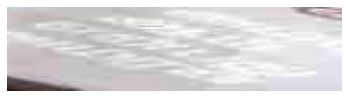

('Actual:', 'சராசரி', 'Prediction:', 'சர-----வ----ி', 'Prediction Corrected:', 'சரவி')


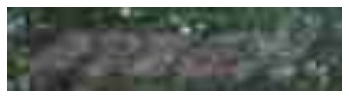

('Actual:', 'மக்களவைத்', 'Prediction:', 'மக-க்களல-வ-த்', 'Prediction Corrected:', 'மகக்களலவத்')


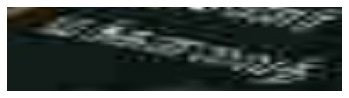

('Actual:', 'இனவாதம்', 'Prediction:', 'இன---------ம்', 'Prediction Corrected:', 'இனம்')


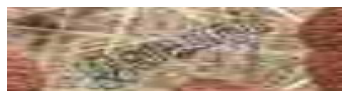

('Actual:', 'மூலதனம்', 'Prediction:', 'மஞ---மாரண--ர்', 'Prediction Corrected:', 'மஞமாரணர்')


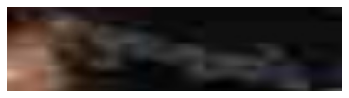

('Actual:', 'வரத', 'Prediction:', 'பன-----------', 'Prediction Corrected:', 'பன')


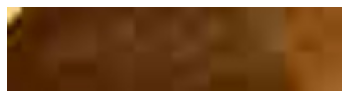

('Actual:', 'பட்டுள்ளன', 'Prediction:', 'பட-டுட்கதனனன-', 'Prediction Corrected:', 'படடுட்கதன')


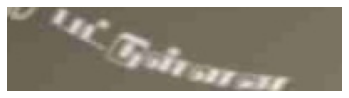

('Actual:', 'அரசு', 'Prediction:', 'அர-----------', 'Prediction Corrected:', 'அர')


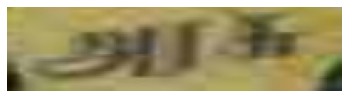

('Actual:', 'ஐதரசன்', 'Prediction:', 'கர---------ல்', 'Prediction Corrected:', 'கரல்')


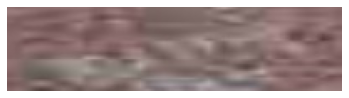

('Actual:', 'தர', 'Prediction:', 'மம-----------', 'Prediction Corrected:', 'ம')


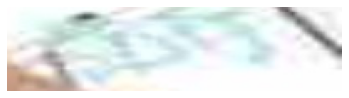

('Actual:', 'தவறின', 'Prediction:', 'கல------ி-ன--', 'Prediction Corrected:', 'கலின')


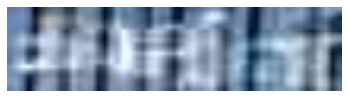

('Actual:', 'படி', 'Prediction:', 'பழ-----------', 'Prediction Corrected:', 'பழ')


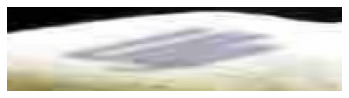

('Actual:', 'அவத்', 'Prediction:', 'ஊ-----------்', 'Prediction Corrected:', 'ஊ்')


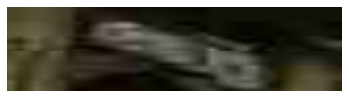

('Actual:', 'சிந்தக', 'Prediction:', 'பர---------ம-', 'Prediction Corrected:', 'பரம')


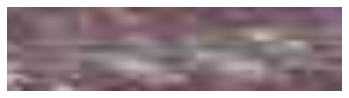

('Actual:', 'உணவாக', 'Prediction:', 'கத-----------', 'Prediction Corrected:', 'கத')


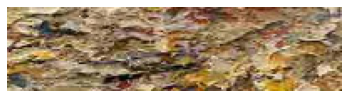

('Actual:', 'மர', 'Prediction:', 'என-----------', 'Prediction Corrected:', 'என')


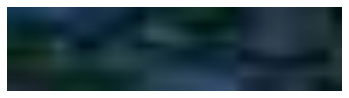

('Actual:', 'கந்தவர்மன்', 'Prediction:', 'அவ----------ை', 'Prediction Corrected:', 'அவை')


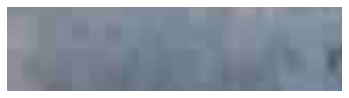

('Actual:', 'பரம்பரை', 'Prediction:', 'பர--ம்பட்ர--ை', 'Prediction Corrected:', 'பரம்பட்ரை')


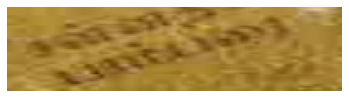

('Actual:', 'என்', 'Prediction:', 'கல-----------', 'Prediction Corrected:', 'கல')


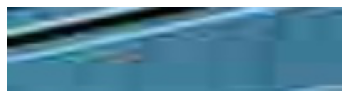

('Actual:', 'நவீனம்', 'Prediction:', 'அர-----------', 'Prediction Corrected:', 'அர')


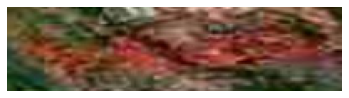

In [45]:
visualize_misclassifications('Train')

('Actual:', 'பழம்', 'Prediction:', 'ஆல----------ா', 'Prediction Corrected:', 'ஆலா')


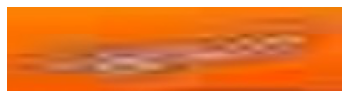

('Actual:', 'எட்டயபுரம்', 'Prediction:', 'ஏப---ப-புர-ம்', 'Prediction Corrected:', 'ஏபபபுரம்')


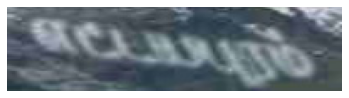

('Actual:', 'கவலை', 'Prediction:', 'சவ-----ள----ை', 'Prediction Corrected:', 'சவளை')


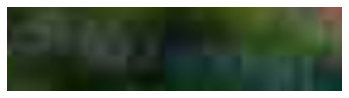

('Actual:', 'எண்', 'Prediction:', 'வவ---------ர்', 'Prediction Corrected:', 'வர்')


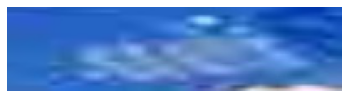

('Actual:', 'பவநாத்', 'Prediction:', 'பல-----ம--த-ு', 'Prediction Corrected:', 'பலமது')


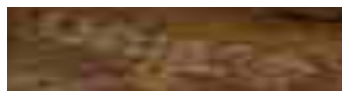

('Actual:', 'எகா', 'Prediction:', 'அர------த்த--', 'Prediction Corrected:', 'அரத்த')


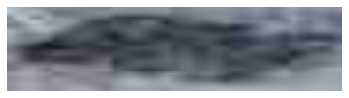

('Actual:', 'கேரமல்', 'Prediction:', 'சக---ர-ா---ம்', 'Prediction Corrected:', 'சகராம்')


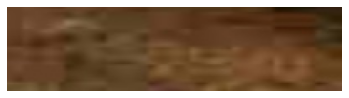

('Actual:', 'அவை', 'Prediction:', 'சன-----------', 'Prediction Corrected:', 'சன')


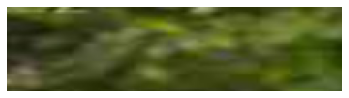

('Actual:', 'மரபணுவமைப்பு', 'Prediction:', 'மரபபனுவவலப்்ப', 'Prediction Corrected:', 'மரபனுவலப்ப')


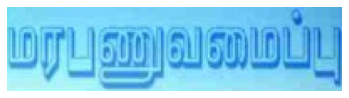

('Actual:', 'ஐசனாவர்', 'Prediction:', 'வ-------க---்', 'Prediction Corrected:', 'வக்')


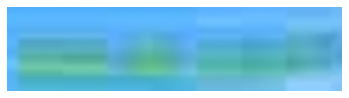

('Actual:', 'இவ்வலகு', 'Prediction:', 'உட-----------', 'Prediction Corrected:', 'உட')


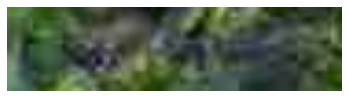

('Actual:', 'அதிக', 'Prediction:', 'அவ-----ிி----', 'Prediction Corrected:', 'அவி')


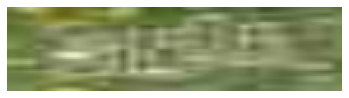

('Actual:', 'பணிகள்', 'Prediction:', 'வல----------்', 'Prediction Corrected:', 'வல்')


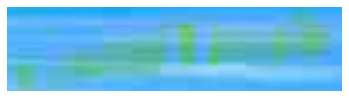

('Actual:', 'கண்டறியப்பட்ட', 'Prediction:', 'அணர்பதிணன்ப்்', 'Prediction Corrected:', 'அணர்பதிணன்ப்')


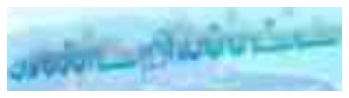

('Actual:', 'அஞ்சலகிரி', 'Prediction:', 'அத----------்', 'Prediction Corrected:', 'அத்')


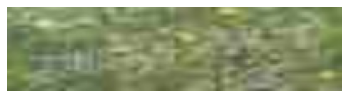

('Actual:', 'இணையியஅணி', 'Prediction:', 'சண--னவ்ங-க-ம்', 'Prediction Corrected:', 'சணனவ்ஙகம்')


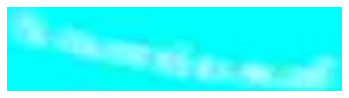

('Actual:', 'உலகம்', 'Prediction:', 'உள----்-ள--ர-', 'Prediction Corrected:', 'உள்ளர')


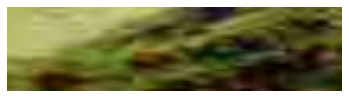

('Actual:', 'பரவ', 'Prediction:', 'பா---------ல-', 'Prediction Corrected:', 'பால')


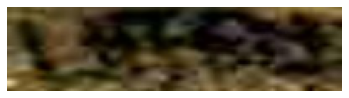

('Actual:', 'உசு', 'Prediction:', 'உம----------்', 'Prediction Corrected:', 'உம்')


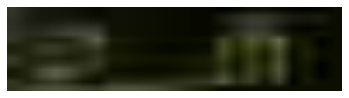

('Actual:', 'அலுவலகத்தில்', 'Prediction:', 'அல-ுவலலக்்திி', 'Prediction Corrected:', 'அலுவலக்தி')


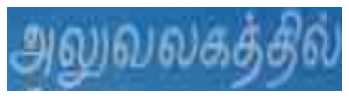

In [46]:
visualize_misclassifications('Val')

('Actual:', 'மகன்', 'Prediction:', 'கச---------ன-', 'Prediction Corrected:', 'கசன')


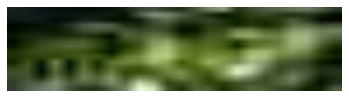

('Actual:', 'அலகுகள்', 'Prediction:', 'ஆள----குுக-ள்', 'Prediction Corrected:', 'ஆளகுகள்')


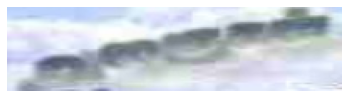

('Actual:', 'ஈழ', 'Prediction:', 'கன-----------', 'Prediction Corrected:', 'கன')


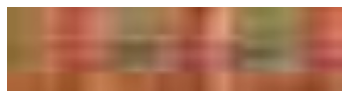

('Actual:', 'சதுரகராதி', 'Prediction:', 'சம-----ண---ம்', 'Prediction Corrected:', 'சமணம்')


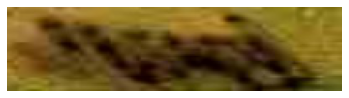

('Actual:', 'அணி', 'Prediction:', 'அய-------ன--ி', 'Prediction Corrected:', 'அயனி')


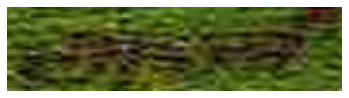

('Actual:', 'அரசிதழ்', 'Prediction:', 'வட----------்', 'Prediction Corrected:', 'வட்')


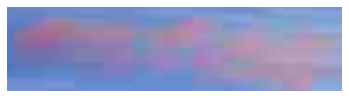

('Actual:', 'ஏப்ரல்', 'Prediction:', 'என-----------', 'Prediction Corrected:', 'என')


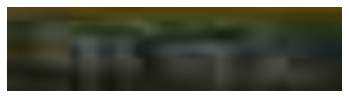

('Actual:', 'மாதவலாயம்', 'Prediction:', 'மர்கவவலலாய-ம்', 'Prediction Corrected:', 'மர்கவலாயம்')


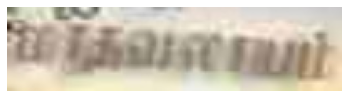

('Actual:', 'அகர', 'Prediction:', 'ஆல-----------', 'Prediction Corrected:', 'ஆல')


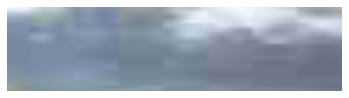

('Actual:', 'நடு', 'Prediction:', 'எ------------', 'Prediction Corrected:', 'எ')


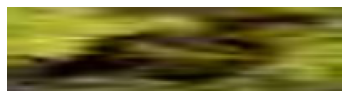

('Actual:', 'ஊர்கள்', 'Prediction:', 'மங----்க---ள்', 'Prediction Corrected:', 'மங்கள்')


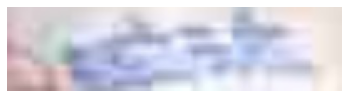

('Actual:', 'சமல்', 'Prediction:', 'சா---------லல', 'Prediction Corrected:', 'சால')


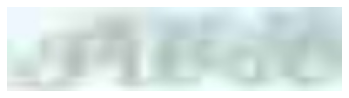

('Actual:', 'ஏலகிரி', 'Prediction:', 'சய-----த----ி', 'Prediction Corrected:', 'சயதி')


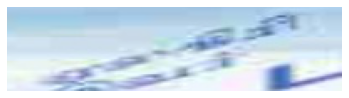

('Actual:', 'பல்', 'Prediction:', 'பர-----------', 'Prediction Corrected:', 'பர')


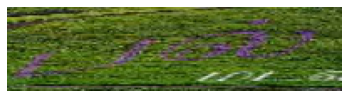

('Actual:', 'ஊடகம்', 'Prediction:', 'எண-----------', 'Prediction Corrected:', 'எண')


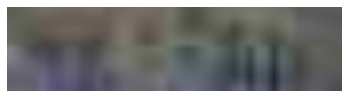

('Actual:', 'தன்', 'Prediction:', 'அத-----------', 'Prediction Corrected:', 'அத')


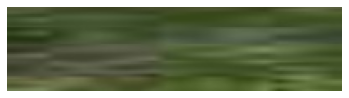

('Actual:', 'எறி', 'Prediction:', 'கல----------ி', 'Prediction Corrected:', 'கலி')


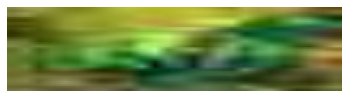

('Actual:', 'மகாமகம்', 'Prediction:', 'நக---ாா-க--ம்', 'Prediction Corrected:', 'நகாகம்')


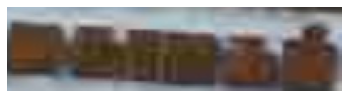

('Actual:', 'இவரது', 'Prediction:', 'ஆத-----த்தத-ு', 'Prediction Corrected:', 'ஆதத்து')


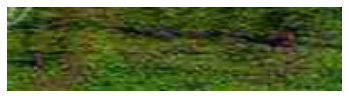

('Actual:', 'உள்ளனர்', 'Prediction:', 'சஅ-----------', 'Prediction Corrected:', 'சஅ')


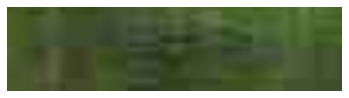

In [47]:
visualize_misclassifications('Test')

### References:
[1] https://github.com/carnotaur/crnn-tutorial/

Loss cannot be reduced beyond 0.54 in val set (after 20 epochs)